In [1]:
# LightGBM machine learning module for MBTdelay
# (C) Mark Mace 2019

In [39]:
# GENERAL INCLUSIONS
import numpy as np
import glob,os
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV


# FOR DATES AND TIMES #
import time
import datetime
from dateutil import tz
from datetime import timedelta
import arrow

In [40]:
# CONVERT UNIX (utc) TIMESTAMP TO YYYY-mm-dd HH:MM:SS (EASTERN)
def conv_unixts_to_east_hms(ts):
    east=arrow.Arrow.fromtimestamp(ts).to('US/Eastern')
    return east.format('YYYY-MM-DD HH:mm:ss')

def get_hour(dt_str):
    return dt_str[11:13]

def get_month_num(dt_str):
    return dt_str[5:7]


# RETURNS DAY OF WEEK 
# M-0, Tu-1, W-2, Th-3 F-4 Sa-6 Su-7
# TAKES YYYY-MM-DD HH:MM:SS RETURNS Day (IN WHATEVER TIMEZONE)
def get_day_of_week(dt):
    dtt = arrow.get(dt)
    return dtt.weekday()

# TAKES UNIX TS RETURNS Day (IN EASTERN/BOSTON)
def get_day_of_week_east_unix(ts):
    east=conv_unixts_to_east_hms(ts)
    return get_day_of_week(east)
    
# TAKES UNIX TS RETURNS Day (IN UTC)
def get_day_of_week_utc_unix(ts):
    utc=conv_unixts_to_utc_hms(ts)
    return get_day_of_week(utc)
    


In [41]:
# another self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Relative Absolute Error (RAE)
def rae(y_true, y_pred):
    return 'RAE', np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(np.mean(y_true) - y_true)), False


In [42]:
### ML SPECIFIC FUNCTIONS
### FOR FEATURE ENGINEERING
# ENCODE EVENT -- 1--event, 0--no event
def bin_event(x):
    x=int(x)
    if(x!=0):
        return 1
    else:
        return 0

# YES OR NO 
def bin_weather(x):
    x=float(x)
    if(x>0):
        return 1
    else:
        return 0
    
# BIN PRECIPITATION TYPE
def bin_ptype(x):
    if(x==1): # None
        return 0
    else: # rain, snow or sleet
        return 0
    
# BIN IN d_bin SECONDS
d_bin=30
def bin_delay(x):
    x=float(x)
    if(x<=0):
        return 0
    else:
        return int(x/d_bin)
    
#BIN IN t_bin DEGREES
t_bin=10
def bin_temp(x):
    x=float(x)
    if(x<=0):
        return 0
    else:
        return int(x/t_bin)
    
        
# PEAK HOUR BIN
def bin_peak(x):
    x=float(x)
    if(6<=x<=10 or 4<=x<=7):
        return 1
    else:
        return 0
           
# WEEKDAY BIN
def bin_weekday(x):
    x=float(x)
    if(x<5):
        return 1 # WEEKDAY
    else:
        return 0 # WEEKEND
    
# SEASON
def bin_season(x):
    x=float(x)
    if(x in {1,2,12}):
        return 0 # WINTER
    elif(x in {3,4,5}):
        return 1 # SPRING
    elif(x in {9,10,11}):
        return 2 # FALL
    elif(x in {6,7,8}):
        return 3 # SUMMER
    else:
        print("NOT A VALID MONTH")
        return -1 # WRONG

In [43]:
# GET DATASETS FROM PRECOMPUTED FILES
MBTdelay_df=[]
ds_files=glob.glob("DS/DS_*.csv")
for ds_f in ds_files:

    station_name,station_id=ds_f.replace("DS/DS_","").replace(".csv","").split("_")
    df_temp=pd.read_csv(ds_f)
    df_temp = df_temp[np.isfinite(df_temp['HEAD_GAP'])]

    MBTdelay_df.append([station_name,station_id,df_temp])
    
MBTdelay_df=np.array(MBTdelay_df)


Feature engineer dataset and perform train-test split based on a number of different criteria
input is dataframe and flags (0--no FE, 1--FE)

In [50]:
# RESULTS OF THE FUNCTION BELOW #
f_combo_1=[0,0,1,0,1,0,1,0,0]
f_combo_2=[0,1,1,0,1,0,1,0,0] # <-- THIS IS THE BEST COMBO

# FEATURE ENGINEER DATA AND PERFORM TRAIN-TEST SPLIT
def feature_engineer_and_split(loc_df,EVENT_FLAG,SNOW_YN_FLAG,RAIN_YN_FLAG,
          WEEKDAY_FLAG,PRECIP_TYP_FLAG,PEAK_FLAG,DELAY_FLAG,SEASON_FLAG,TEMP_FLAG,split_perc,shuffle_flag):
    
#     print(np.mean(test_df['HEAD_GAP']))
    fe_df=loc_df[np.isfinite(loc_df['TEMP'])].copy()

    if(EVENT_FLAG==1):
        fe_df['event']=fe_df['event'].apply(lambda x: bin_weather(x))

    if(SNOW_YN_FLAG==1):
        fe_df['PRECIP_ACC']=fe_df['PRECIP_ACC'].apply(lambda x: bin_weather(x))

    if(RAIN_YN_FLAG==1):
        fe_df['PRECIP_INT']=fe_df['PRECIP_INT'].apply(lambda x: bin_weather(x))

    if(WEEKDAY_FLAG==1):
        fe_df['DOW']=fe_df['DOW'].apply(lambda x: bin_weekday(x))
        
    if(PRECIP_TYP_FLAG==1):
        fe_df['PRECIP_TYP_ENC']=fe_df['PRECIP_TYP_ENC'].apply(lambda x: bin_ptype(x))

    if(PEAK_FLAG==1):
        fe_df['HOUR_BIN']=fe_df['HOUR_BIN'].apply(lambda x: bin_peak(x))

    if(DELAY_FLAG==1):
        fe_df['HEAD_GAP']=fe_df['HEAD_GAP'].apply(lambda x: bin_delay(x))

    if(SEASON_FLAG==1):
        fe_df['MONTH_BIN']=fe_df['MONTH_BIN'].apply(lambda x: bin_season(x))
        
    if(TEMP_FLAG==1):
        fe_df['TEMP']=fe_df['TEMP'].apply(lambda x: bin_temp(x))


    all_x=np.transpose(np.array([fe_df['HOUR_BIN'], fe_df['DOW'], fe_df['MONTH_BIN'],
                                fe_df['event'],fe_df['PRECIP_TYP_ENC'],
                                fe_df['PRECIP_INT'], fe_df['PRECIP_ACC'], 
                                fe_df['PRECIP_PRO'], fe_df['TEMP']],dtype=np.float32))

    all_y=np.array([fe_df['HEAD_GAP']],dtype=np.float32)[0]


    X_train, X_test, y_train, y_test = train_test_split(all_x, all_y, test_size=split_perc, random_state=0,shuffle=shuffle_flag)
    
    return X_train, X_test, y_train, y_test 


In [51]:
## THIS IS JUST FOR TESTING ##

# TEST STATION NUMBER # 
station_num_id=3

test_size=0.2

# LOCAL DATAFRAME
df_loc=MBTdelay_df[station_num_id][2]
df_loc = df_loc[np.isfinite(df_loc['HEAD_GAP'])]

X_train, X_test, y_train, y_test=feature_engineer_and_split(df_loc, 0,1,1,0,1,0,1,0,0, test_size,False)
# X_train, X_test, y_train, y_test=feature_engineer_and_split(df_loc,0,1,1,0,1,0,1,0,0,0.2) # FEATURE ENGINEERED

# CREATE DATASET FOR LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# SPECIFY PARAMETERS
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 8,
    'learning_rate': 0.12,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('The rae of prediction is:', rae(y_test, y_pred)[1])
print('Variance score: ',r2_score(y_test,y_pred))


Starting training...
[1]	valid_0's rmse: 8.77528
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 8.74344
[3]	valid_0's rmse: 8.73825
[4]	valid_0's rmse: 8.71271
[5]	valid_0's rmse: 8.71222
[6]	valid_0's rmse: 8.69358
[7]	valid_0's rmse: 8.67888
[8]	valid_0's rmse: 8.66356
[9]	valid_0's rmse: 8.6511
[10]	valid_0's rmse: 8.64013
[11]	valid_0's rmse: 8.6341
[12]	valid_0's rmse: 8.62992
[13]	valid_0's rmse: 8.63249
[14]	valid_0's rmse: 8.63454
[15]	valid_0's rmse: 8.6298
[16]	valid_0's rmse: 8.63194
[17]	valid_0's rmse: 8.62951
[18]	valid_0's rmse: 8.62845
[19]	valid_0's rmse: 8.62336
[20]	valid_0's rmse: 8.62191
Did not meet early stopping. Best iteration is:
[20]	valid_0's rmse: 8.62191
Saving model...
Starting predicting...
The rmse of prediction is: 8.621911502404457
The rae of prediction is: 0.8703029104974032
Variance score:  -0.08835257548435438


In [52]:
print(y_test,y_pred,y_pred-y_test)

[1. 6. 4. ... 3. 1. 4.] [2.07380994 2.07380994 2.24757028 ... 1.87818938 1.87818938 1.87818938] [ 1.07380994 -3.92619006 -1.75242972 ... -1.12181062  0.87818938
 -2.12181062]


Determine model parameters for each station using fixed parameters

In [48]:
# BUFFERS FOR ANALYTICS
data_metrics=[]
model_outcomes=[]

# TRAIN-TEST SPLIT
test_size=0.2

# PARAMETERS DETERMINED FROM CV SCAN 
params_prod = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 8,
    'learning_rate': 0.12,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# RUN MODEL FOR ALL STATIOS AND SAVE TO FILE #
for station_num_id in range(len(MBTdelay_df)):
    
    # LOAD DATAFRAME 
    station_name=MBTdelay_df[station_num_id][0]
    station_id=MBTdelay_df[station_num_id][1]
    test_df=MBTdelay_df[station_num_id][2].copy()

    # SIMPLE STATS FOR DATA FOR A STATION
    gap_mode=stats.mode(test_df['HEAD_GAP'].values)
    gap_mean=np.mean(test_df['HEAD_GAP'])
    gap_mean_unc=np.std(test_df['HEAD_GAP'])/np.sqrt(len(test_df['HEAD_GAP']))
    
    # SAVE METRICS TO ARRAY 
    data_metrics.append([station_name,station_id,
                    gap_mode,
                    gap_mean,
                    gap_mean_unc
                    ])
    
    # GENERATE TEST-TRAIN SPLIT -- USES FEATURE ENGINEERING DETERMINED PREVIOUSLY #
    X_train, X_test, y_train, y_test=feature_engineer_and_split(test_df, 0,1,1,0,1,0,1,0,0, test_size,True)
    
    
    # CREATE DATASET FOR LIGHTGBM
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)


    print('Starting training...')
    # TRAIN
    gbm = lgb.train(params_prod,
                    lgb_train,
                    num_boost_round=20,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=5)

    print('Saving model...')
    # SAVE MODEL TO FILE
    gbm.save_model('LGB_MODEL/'+station_name+'_'+station_id+'.txt')

    print('Starting predicting...')
    # PERFORM PREDICTION FOR METRICS
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
  
    # EVALUATE METRICS
    mae=metrics.mean_absolute_error(y_test, y_pred)
    mse=metrics.mean_squared_error(y_test, y_pred)
    rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2=r2_score(y_test,y_pred)
    
    # SAVE MODEL METRICS
    model_outcomes.append([station_name,station_id,mae,mse,rmse,r2])

model_outcomes=np.array(model_outcomes)


Starting training...
[1]	valid_0's rmse: 1.87193
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 1.87039
[3]	valid_0's rmse: 1.86913
[4]	valid_0's rmse: 1.86671
[5]	valid_0's rmse: 1.86578
[6]	valid_0's rmse: 1.86445
[7]	valid_0's rmse: 1.86337
[8]	valid_0's rmse: 1.86156
[9]	valid_0's rmse: 1.85984
[10]	valid_0's rmse: 1.85846
[11]	valid_0's rmse: 1.85789
[12]	valid_0's rmse: 1.85681
[13]	valid_0's rmse: 1.85585
[14]	valid_0's rmse: 1.85562
[15]	valid_0's rmse: 1.85523
[16]	valid_0's rmse: 1.85512
[17]	valid_0's rmse: 1.85471
[18]	valid_0's rmse: 1.85445
[19]	valid_0's rmse: 1.85419
[20]	valid_0's rmse: 1.85405
Did not meet early stopping. Best iteration is:
[20]	valid_0's rmse: 1.85405
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 4.82239
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 4.75026
[3]	valid_0's rmse: 4.73636
[4]	valid_0's rmse: 4.68093
[5]	valid_0's rmse: 4.66799
[6]	valid

Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 3.39095
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 3.37771
[3]	valid_0's rmse: 3.36732
[4]	valid_0's rmse: 3.35511
[5]	valid_0's rmse: 3.34729
[6]	valid_0's rmse: 3.3421
[7]	valid_0's rmse: 3.3339
[8]	valid_0's rmse: 3.33083
[9]	valid_0's rmse: 3.32434
[10]	valid_0's rmse: 3.31811
[11]	valid_0's rmse: 3.31547
[12]	valid_0's rmse: 3.312
[13]	valid_0's rmse: 3.30971
[14]	valid_0's rmse: 3.30825
[15]	valid_0's rmse: 3.30556
[16]	valid_0's rmse: 3.30306
[17]	valid_0's rmse: 3.30104
[18]	valid_0's rmse: 3.29855
[19]	valid_0's rmse: 3.29733
[20]	valid_0's rmse: 3.29406
Did not meet early stopping. Best iteration is:
[20]	valid_0's rmse: 3.29406
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 5.26309
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 5.20938
[3]	valid_0's rmse: 5.20079
[4]	valid_0's rmse: 5.15847
[5

Starting training...
[1]	valid_0's rmse: 5.16919
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 5.14546
[3]	valid_0's rmse: 5.12189
[4]	valid_0's rmse: 5.11022
[5]	valid_0's rmse: 5.09002
[6]	valid_0's rmse: 5.07837
[7]	valid_0's rmse: 5.068
[8]	valid_0's rmse: 5.05976
[9]	valid_0's rmse: 5.05232
[10]	valid_0's rmse: 5.04549
[11]	valid_0's rmse: 5.04217
[12]	valid_0's rmse: 5.04165
[13]	valid_0's rmse: 5.03541
[14]	valid_0's rmse: 5.03118
[15]	valid_0's rmse: 5.02961
[16]	valid_0's rmse: 5.02111
[17]	valid_0's rmse: 5.01857
[18]	valid_0's rmse: 5.01686
[19]	valid_0's rmse: 5.01546
[20]	valid_0's rmse: 5.01281
Did not meet early stopping. Best iteration is:
[20]	valid_0's rmse: 5.01281
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 6.01479
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 5.88192
[3]	valid_0's rmse: 5.87437
[4]	valid_0's rmse: 5.76562
[5]	valid_0's rmse: 5.75916
[6]	valid_0

Starting training...
[1]	valid_0's rmse: 1.01075
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 1.00393
[3]	valid_0's rmse: 1.00063
[4]	valid_0's rmse: 0.994968
[5]	valid_0's rmse: 0.993197
[6]	valid_0's rmse: 0.990105
[7]	valid_0's rmse: 0.988514
[8]	valid_0's rmse: 0.986408
[9]	valid_0's rmse: 0.983925
[10]	valid_0's rmse: 0.983238
[11]	valid_0's rmse: 0.982781
[12]	valid_0's rmse: 0.982409
[13]	valid_0's rmse: 0.978741
[14]	valid_0's rmse: 0.976016
[15]	valid_0's rmse: 0.975448
[16]	valid_0's rmse: 0.974748
[17]	valid_0's rmse: 0.974532
[18]	valid_0's rmse: 0.974433
[19]	valid_0's rmse: 0.974173
[20]	valid_0's rmse: 0.97439
Did not meet early stopping. Best iteration is:
[19]	valid_0's rmse: 0.974173
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 5.51033
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 5.43676
[3]	valid_0's rmse: 5.42633
[4]	valid_0's rmse: 5.36873
[5]	valid_0's rmse: 

Starting training...
[1]	valid_0's rmse: 5.20232
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 5.00665
[3]	valid_0's rmse: 5.00215
[4]	valid_0's rmse: 4.84035
[5]	valid_0's rmse: 4.83864
[6]	valid_0's rmse: 4.70929
[7]	valid_0's rmse: 4.61224
[8]	valid_0's rmse: 4.53046
[9]	valid_0's rmse: 4.4624
[10]	valid_0's rmse: 4.41821
[11]	valid_0's rmse: 4.37459
[12]	valid_0's rmse: 4.34013
[13]	valid_0's rmse: 4.33772
[14]	valid_0's rmse: 4.33616
[15]	valid_0's rmse: 4.30993
[16]	valid_0's rmse: 4.30824
[17]	valid_0's rmse: 4.29748
[18]	valid_0's rmse: 4.29037
[19]	valid_0's rmse: 4.2856
[20]	valid_0's rmse: 4.27933
Did not meet early stopping. Best iteration is:
[20]	valid_0's rmse: 4.27933
Saving model...
Starting predicting...
Starting training...
[1]	valid_0's rmse: 1.32686
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 1.31985
[3]	valid_0's rmse: 1.31867
[4]	valid_0's rmse: 1.31332
[5]	valid_0's rmse: 1.31131
[6]	valid_0

In [31]:
results=[]
for x in np.unique(MBTdelay_df[:,0]):
    
    results.append([x,np.average(model_outcomes[np.where(model_outcomes[:,0]==x)][:,5].astype(float))])
    
results=np.array(results)


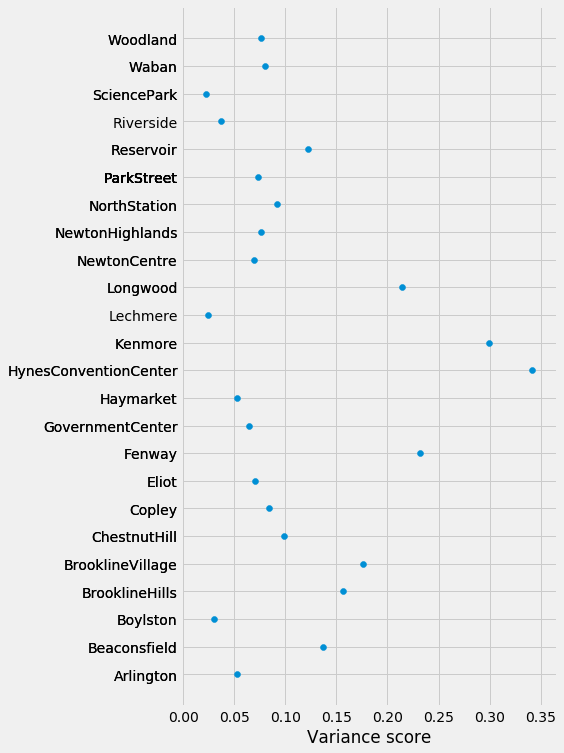

In [33]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (6,12))

xnames=[MBTdelay_df[i][0] for i in range(len(MBTdelay_df[:,2]))]
plt.scatter(results[:,1].astype(float),results[:,0])

# plt.scatter(results[:,0],results[:,1].astype(float),)
# plt.title("All stations")
# plt.xlabel("Training loss (MSE)")
plt.xlabel("Variance score")
# xr=np.arange(0,250000)
# plt.plot(xr,xr,label="1:1",color="C1")
plt.yticks(xnames)

# plt.legend()
# plt.tight_layout

plt.savefig("FIGS/LGBM_train_test_err.pdf")

In [14]:
# station_num_id=3
# split_fraction=0.2

# station_df=MBTdelay_df[station_num_id][2]

# results=[run_model_fit(station_name,station_num_id,EVENT_FLAG,SNOW_YN_FLAG,RAIN_YN_FLAG,WEEKDAY_FLAG,PRECIP_TYP_FLAG,PEAK_FLAG,DELAY_FLAG,SEASON_FLAG,TEMP_FLAG,split_fraction) 
#          for EVENT_FLAG in {0,1}
#          for SNOW_YN_FLAG in {0,1}
#          for RAIN_YN_FLAG in {0,1}
#          for WEEKDAY_FLAG in {0,1}
#          for PRECIP_TYP_FLAG in {0,1}
#          for PEAK_FLAG in {0,1}
#          for DELAY_FLAG in {0,1}
#          for SEASON_FLAG in {0,1}
#          for TEMP_FLAG in {0,1}
#         ]


Random and grid search for optimal parameters

In [17]:
# TEST STATION NUMBER # 
test_station_id_num = 3


station_name = MBTdelay_df[test_station_id_num][0]
station_id = MBTdelay_df[test_station_id_num][1]


test_size = 0.2

# LOCAL DATAFRAME
df_loc = MBTdelay_df[test_station_id_num][2]
df_loc = df_loc[np.isfinite(df_loc['HEAD_GAP'])]

X_train, X_test, y_train, y_test = feature_engineer_and_split(df_loc,0,1,1,0,1,0,1,0,0,test_size)



Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.5s finished


The rae of prediction is: 0.9410818999598491
The mse of prediction is: 27.276769835624485
The rmse of prediction is: 5.222716710259564
The r2 of prediction is: 0.09539992112146478
Best parameters found by grid search are: {'num_leaves': 12, 'n_estimators': 60, 'learning_rate': 0.1, 'feature_fraction': 0.7, 'boosting': 'gbdt', 'bagging_freq': 0, 'bagging_fraction': 0.7}


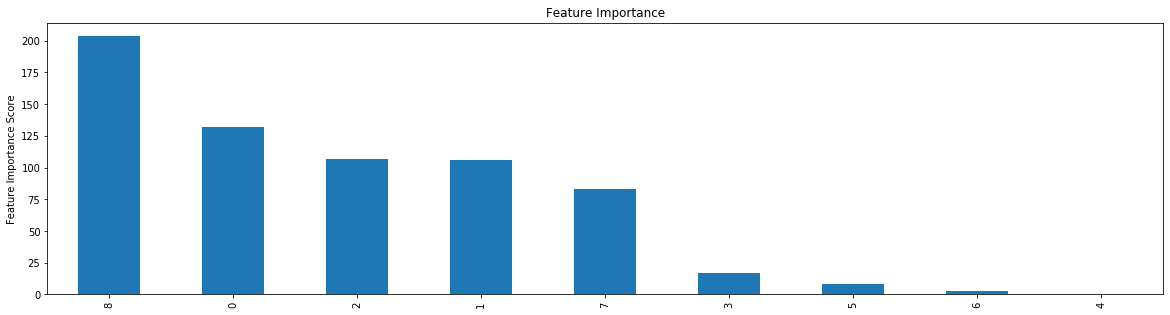

In [28]:
# CV RANDOM SEARCH


estimator = lgb.LGBMRegressor()

param_grid = {
    'boosting' : ['gbdt', 'dart'],
    'num_leaves': [10, 20, 30, 40, 50],
    'learning_rate': [ 0.05, 0.1, 0.12],
    'n_estimators': [50, 60, 80, 100],
    'num_leaves': [8, 10, 12 ],
    'bagging_fraction': [0.7, 0.8, 0.9],
    'learning_rate': [0.01, 0.05, 0.10, 0.20, 0.5, 1.0],
    'feature_fraction': [0.5,0.7,0.9],
    'bagging_freq': [0,1,2,5]
}

grid = RandomizedSearchCV(estimator, param_grid, verbose=1, cv=10, n_jobs = -1 ,n_iter=10)
grid.fit(X_train, y_train)

# PREDICTION AND METRICS
y_pred = grid.predict(X_test)

print('The rae of prediction is:', rae(y_test, y_pred)[1])
print('The mse of prediction is:', metrics.mean_squared_error(y_test, y_pred))
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('The r2 of prediction is:', metrics.r2_score(y_test, y_pred))
print('Best parameters found by grid search are:', grid.best_params_)

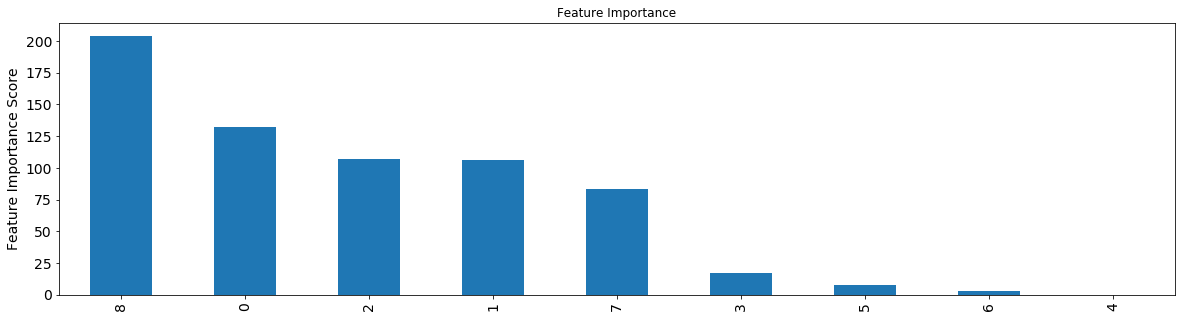

In [78]:
#fe_df['HOUR_BIN'], fe_df['DOW'], fe_df['MONTH_BIN'],fe_df['event'],fe_df['PRECIP_TYP_ENC'],fe_df['PRECIP_INT'], fe_df['PRECIP_ACC'], fe_df['PRECIP_PRO'], fe_df['TEMP']
feat_label=['Hour of day','Day of week','Month of year','Event','Precip type','Rain intensity','Snow accum.','Precipitation probability','Temperature']
X_train_col=pd.DataFrame(X_train)
#FEATURE IMPORTANCE 
predictors = [x for x in X_train_col.columns]
feat_imp = pd.Series(grid.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance',fontsize=14)
plt.ylabel('Feature Importance Score',fontsize=14)
plt.savefig('FIGS/feature_imp.pdf')

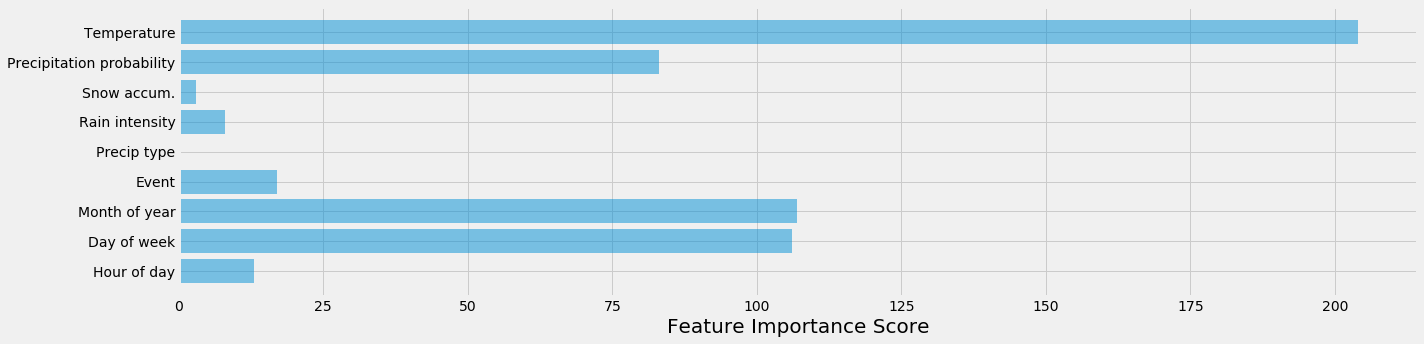

In [94]:
plt.style.use('fivethirtyeight')

feat_label=['Hour of day','Day of week','Month of year','Event','Precip type','Rain intensity','Snow accum.','Precipitation probability','Temperature']


feat_imp_data=[13,106,107,17,0,8,3,83,204]

y_pos = np.arange(len(feat_imp_data))

plt.barh(y_pos, feat_imp_data, align='center', alpha=0.5)
plt.yticks(y_pos, feat_label)

plt.rcParams['figure.figsize'] = 20, 5
plt.plot(kind='bar',title='Feature Importance')
plt.xlabel('Feature Importance Score',fontsize=20)
ax.tick_params(axis="y", labelsize=20)

plt.tight_layout()
plt.savefig('FIGS/feature_imp_lbl.pdf')


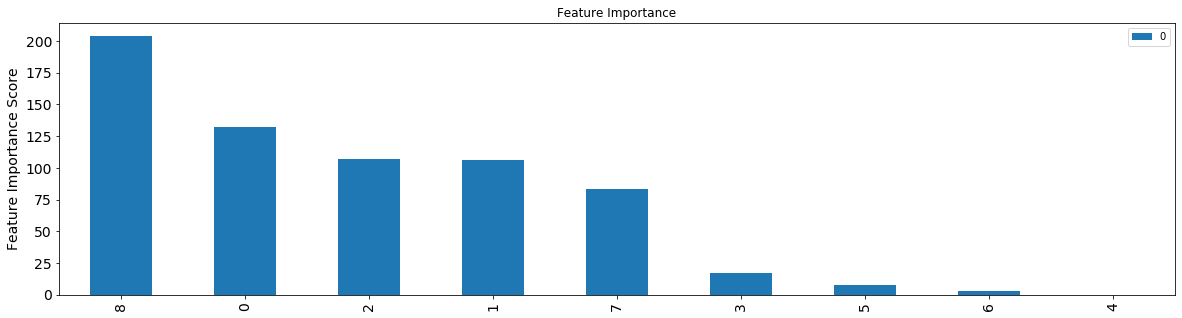

In [ ]:
# CV GRID SEARCH
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.05, 0.1, 0.12],
    'n_estimators': [50, 60, 80, 100],
    'num_leaves': [8, 10, 12 ],
    'bagging_fraction': [0.8,0.9],
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)
print('The rae of prediction is:', rae(y_test, y_pred)[1])
print('The mse of prediction is:', metrics.mean_squared_error(y_test, y_pred))
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('The r2 of prediction is:', metrics.r2_score(y_test, y_pred))
print('Best parameters found by grid search are:', gbm.best_params_)

In [ ]:
# Best parameters found by grid search are: 
# {'bagging_fraction': 0.8, 'learning_rate': 0.12, 'n_estimators': 100, 'num_leaves': 8}

In [ ]:
# PRACTICE LOAD